In [1]:
# %matplotlib notebook
# NBVAL_IGNORE_OUTPUT
#%load_ext watermark
import weylchamber
from weylchamber.visualize import WeylChamber
#%watermark -v --iversions

import numpy as np
import qutip as qt
from qutip.qip.operations import cnot, iswap, sqrtiswap

import time
import pickle
 
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Operators
a1 = qt.tensor([qt.destroy(3), qt.qeye(3), qt.qeye(3)])
a2 = qt.tensor([qt.qeye(3), qt.destroy(3), qt.qeye(3)])
a = [a1, a2]
aTB = qt.tensor([qt.qeye(3), qt.qeye(3), qt.destroy(3)])
nTB = aTB.dag()*aTB

# Construct bare states.
# Later dressed states that are closest to those will be calculated.
fock0 = qt.basis(3, 0)
fock1 = qt.basis(3, 1)
psiBare = [qt.tensor([fock1, fock0, fock0]),
           qt.tensor([fock0, fock1, fock0]),
           qt.tensor([fock0, fock0, fock1]),
           qt.tensor([fock0, fock0, fock0]),
           qt.tensor([fock1, fock1, fock0])]


### Static case study device (see Appendix A)

In [3]:
def get_Hs(params):
    # Construct Hamiltonian
    Hs = params['alphaTB']/2*aTB.dag()*aTB.dag()*aTB*aTB
    for ii in range(0, 2):
        Hs += (params['omega'][ii] * a[ii].dag() * a[ii] +
               params['alpha'][ii]/2 * a[ii].dag() * a[ii].dag() * a[ii] * a[ii] +
               params['g'][ii] * (a[ii].dag()+a[ii]) * (aTB.dag()+aTB))
    return Hs


def omegaTB(Phi, params):
    '''Return coupler frequency for given flux Phi'''
    return params['omegaTB0']*np.sqrt(np.abs(np.cos(np.pi*Phi)))


def dressedFreq(Phi):
    '''Find dressed frequencies for qubit 1, 2 and coupler'''
    eigvals, eigvecs = (Hs+omegaTB(Phi,params)*nTB).eigenstates()

    return [eigvals[np.argmax(qt.expect(psi*psi.dag(), eigvecs))]
            for psi in psiBare]

### Driven device

In [4]:
def H1(t, args):
    '''Callback function for defining H1(t)'''
    delta = args['delta']
    Theta = params['Theta']
    if args['pulsed']:
        return omegaTB(Theta+delta*flat_gauss(t,args)*np.cos(args['omegaPhi']*t), params)
    else:
        return omegaTB(Theta+delta*np.cos(args['omegaPhi']*t), params)

def flat_gauss(t, args):
    σ = args['σ']
    pulse_dur = args['pulse_dur']
    offset = np.exp(-2)
    scale  = 1-offset
    if t<2*σ:
        return (1-np.exp(-(t/σ)**2/2))/scale
    
    elif t>=2*σ and t<2*σ + pulse_dur:
        return 1
    
    elif t>=(2*σ + pulse_dur) and t<=4*σ + pulse_dur:
        t0 = 2*σ + pulse_dur
        return (np.exp(-((t-t0)/σ)**2/2)-offset)/scale
    
    else:
        return 0
    

def fluxPump(omegaPhi, psi0, tlist, args):
    '''Time evolution for flux pumping'''
    args_loc = args.copy()
    args_loc['omegaPhi'] = omegaPhi
    # Full (time dependent) Hamiltonian: H(t) = Hs + H1(t)*nTB
    Ht = [Hs, [nTB, H1]]
    result = qt.mesolve(Ht, psi0, tlist, c_ops=cops, e_ops=eops, args=args_loc)
    return [np.real(result.expect[0]), np.real(result.expect[1])]


def fluxPump_weyl_old(tlist, args):
    '''Time evolution for flux pumping'''
   
    # Full (time dependent) Hamiltonian: H(t) = Hs + H1(t)*nTB
    Ht = [Hs, [nTB, H1]]
    unit_ls = qt.propagator(Ht, tlist, c_ops=[], e_ops=[], args=args, parallel=True)
    unit_ls = [(U_op.dag()*u*U_op) for u in unit_ls]
    unit_red_ls = [u.extract_states([0,3,9,12]) for u in unit_ls]
    leakage  = [1-abs((u*u.dag()).tr())/4 for u in unit_red_ls]
    coords  = [weylchamber.c1c2c3(u) for u in unit_red_ls]
    return coords, leakage

def fluxPump_weyl(tlist, args):
    '''Time evolution for flux pumping'''
   
    # Full (time dependent) Hamiltonian: H(t) = Hs + H1(t)*nTB
    Ht = [Hs, [nTB, H1]]
    unit_ls = [qt.propagator(Ht, tlist, c_ops=[], e_ops=[], args=args, parallel=True)[-1]]
    unit_ls = [(U_op.dag()*u*U_op) for u in unit_ls]
    unit_red_ls = [u.extract_states([0,3,9,12]) for u in unit_ls]
    leakage  = [1-abs((u*u.dag()).tr())/4 for u in unit_red_ls]
    coords  = [weylchamber.c1c2c3(u) for u in unit_red_ls]
    return coords, np.abs(leakage)

### Specify 2Q device parameters

In [5]:
# these two need to be set
freq_l = 4.5 # the lower qubit freq (GHz)
freq_h = 6.8 # the higher qubit freq (GHz)

params = {
'omega': np.array([freq_l, freq_h])*1e9*2*np.pi,  # Qubit frequencies (Hz)
'alpha' : np.array([-205, -205])*1e6*2*np.pi,  # Qubit anharmonicities (Hz)
'T1' : np.array([100, 100])*1e-6,  # Qubit T1's (s)
'T2' : np.array([80, 80])*1e-6,  # Qubit T2's (s)
'g' : np.array([185, 195])*1e6*2*np.pi,  # Qubit-coupler coupling rates (Hz)
'omegaTB0' : 9.2e9*2*np.pi,  # Coupler frequency at zero flux (Hz)
'alphaTB' : 150e6*2*np.pi, # Coupler anharmmonicity (Hz)
}

### Plot spectrum for qubits and coupler

10.4%. Run time:   0.20s. Est. time left: 00:00:00:01
20.4%. Run time:   0.23s. Est. time left: 00:00:00:00
30.3%. Run time:   0.26s. Est. time left: 00:00:00:00
40.3%. Run time:   0.29s. Est. time left: 00:00:00:00
50.2%. Run time:   0.31s. Est. time left: 00:00:00:00
60.2%. Run time:   0.34s. Est. time left: 00:00:00:00
70.1%. Run time:   0.36s. Est. time left: 00:00:00:00
80.1%. Run time:   0.38s. Est. time left: 00:00:00:00
90.0%. Run time:   0.41s. Est. time left: 00:00:00:00
100.0%. Run time:   0.43s. Est. time left: 00:00:00:00
Total run time:   0.44s


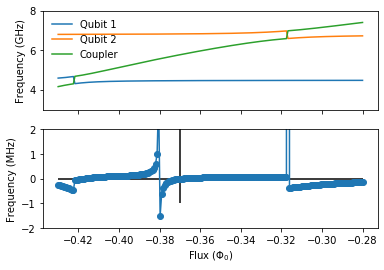

In [6]:
Hs = get_Hs(params)
Philist = np.linspace(-0.43, -0.28, 201)
omegaD = np.array(qt.parallel_map(dressedFreq, Philist, progress_bar=True)).T

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
for row in range(3):
    ax1.plot(Philist, omegaD[row, :]/(2*np.pi)/1e9)
ax1.set_ylabel('Frequency (GHz)')
ax1.legend(['Qubit 1', 'Qubit 2', 'Coupler'], frameon=False)
ax1.set_ylim([3,8])
ZZinMHz = (omegaD[4,:]+omegaD[3,:]-omegaD[0,:]-omegaD[1,:])/2/np.pi/1e6
assert min(abs(ZZinMHz)) < 0.1 # make sure this works
params['Theta'] = Philist[np.argmin(abs(ZZinMHz))]
ax2.plot(Philist, ZZinMHz,'-o')
ax2.set_ylabel('Frequency (MHz)')
ax2.set_ylim([-2,2])
plt.vlines(params['Theta'], -1, 7.5)
plt.hlines(0, Philist[0],Philist[-1])
plt.xlabel(r'Flux $(\Phi_0)$')
plt.show()

### This is the zero-ZZ crosstalk bias point that we will bias the device at for our simulation

In [7]:
params['Theta']

-0.37

# Set entangling pulse drive amplitude to a low strength. Simulate standard iSWAP-like entanglement

12.2%. Run time:   5.45s. Est. time left: 00:00:00:39
22.0%. Run time:   5.58s. Est. time left: 00:00:00:19
31.7%. Run time:   5.71s. Est. time left: 00:00:00:12
41.5%. Run time:   5.78s. Est. time left: 00:00:00:08
51.2%. Run time:  10.59s. Est. time left: 00:00:00:10
61.0%. Run time:  10.73s. Est. time left: 00:00:00:06
70.7%. Run time:  10.84s. Est. time left: 00:00:00:04
80.5%. Run time:  10.96s. Est. time left: 00:00:00:02
90.2%. Run time:  11.11s. Est. time left: 00:00:00:01
100.0%. Run time:  14.90s. Est. time left: 00:00:00:00
Total run time:  14.92s
Pop transfer:  0.996992386419128


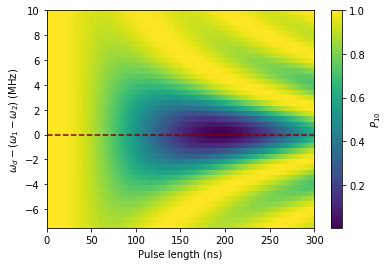

In [8]:
#################
#################
#################
### Important parameters to change

# delta is the entangling pulse drive strength. A nonstandard trajectory will result from strong drive effects/stark shifting
delta = 0.005 # delta <0.01 should give a standard trajectory. Above >0.01 trajectory should deviate more and more
max_tlist = 300e-9 # This number (in s) is the x axis limit of the below plot. It should be long enough to see an iSWAP.
# Once you know the iSWAP length, you can change the next cell max_tlist accordingly so your trajectory can reach iSWAP.

#################
#################
#################

# %%
# Find dressed frequencies and states
H = (Hs+omegaTB(params['Theta'], params)*nTB)
eigvals, eigvecs = H.eigenstates()
index = np.argmax(qt.expect(psiBare[0]*psiBare[0].dag(), eigvecs))
psiD10 = eigvecs[index]
omegaD10 = eigvals[index]
index = np.argmax(qt.expect(psiBare[1]*psiBare[1].dag(), eigvecs))
psiD01 = eigvecs[index]
omegaD01 = eigvals[index]
index = np.argmax(qt.expect(psiBare[2]*psiBare[2].dag(), eigvecs))
psiDTB = eigvecs[index]
omegaDTB = eigvals[index]
# %%

# Find dressed frequencies and states

U, s, V = np.linalg.svd(H.full())
permut_order = np.argmax(np.abs(V), axis=0)
undo_permut = np.arange(len(permut_order))
undo_permut[permut_order] = range(len(permut_order))
# s_ord = s[permut_order]
V_ord = V[permut_order, :]
U_ord = U[:, permut_order]
V_op = qt.Qobj(V_ord, dims = [[3,3,3], [3,3,3]])
U_op = qt.Qobj(U_ord, dims = [[3,3,3], [3,3,3]])
#
eops = [U_op*psiBare[0]*psiBare[0].dag()*U_op.dag(), U_op*psiBare[1]*psiBare[1].dag()*U_op.dag()]#
# eops = [psiD10*psiD10.dag(), psiD01*psiD01.dag()]
cops = []
# Include T1, T2 & temperature in simulation.
# This will take much more time and finer time steps. I haven't tried this yet.
#for ii in range(0, 2):
#    cops.append(np.sqrt(1/T1[ii])*a[ii])
#    cops.append(np.sqrt(1/T2[ii]-1/(2*T1[ii]))*(a[ii].dag()*a[ii]))
psi0 = psiD10
omegaPhi0 = omegaD10 - omegaD01
tlist = np.linspace(0, max_tlist, 501)
#tlist = np.linspace(0, 0.5e-6, 501)
omegaPhi = np.linspace(omegaPhi0-7.5e6*2*np.pi, omegaPhi0+10e6*2*np.pi, 41)
# omegaPhi = np.linspace(omegaPhi0, omegaPhi0+30e6*2*np.pi, 41)

args = {'delta'   : delta,
        'pulse_dur':max_tlist,
        'σ'       : 10e-9,
        'pulsed'  : True
             }
result = np.array(qt.parallel_map(fluxPump, omegaPhi,
                                  task_args=(psi0, tlist, args),
                                  progress_bar=True))
# %%
p10M = result[:, 0, :]
p01M = result[:, 1, :]
print('Pop transfer: ',np.max(p01M))
omegaPhi_iSWAP = omegaPhi[np.argmin(np.min(p10M,axis=1))] #figure out the drive freq

plt.close(2)
plt.figure(2)
# plt.plot(p10M[26])
# plt.show()
plt.imshow(p10M, origin='lower', aspect='auto',
           extent=[tlist[0]/1e-9, tlist[-1]/1e-9,
                   (omegaPhi[0]-omegaPhi0)/(2*np.pi)/1e6,
                   (omegaPhi[-1]-omegaPhi0)/(2*np.pi)/1e6])
plt.hlines(y=(omegaPhi_iSWAP-omegaPhi0)/(2*np.pi)/1e6, xmin=0, xmax = tlist[-1]/1e-9, linestyle='--', color='maroon')
plt.colorbar(label='$P_{10}$')
plt.xlabel('Pulse length (ns)')
plt.ylabel(r'$\omega_d - (\omega_1-\omega_2)$ (MHz)')
plt.show()

## Simulate the Cartan trajectory at this low entangling pulse drive strength

In [9]:
#################
#################
#################
### Important parameters to change

t_f_max = 200e-9 # This number (in s) is the max entangling pulse duration. It should be roughly the length of an iSWAP.

#################
#################
#################

num_pts = 11 # number of trajectory points to calculate
t_f_list = np.linspace(4e-9, t_f_max, num_pts)

args = {'omegaPhi': omegaPhi_iSWAP,
        'delta'   : delta,
        'pulse_dur':400e-9,
        'σ'       : 10e-9,
        'pulsed'  : True
             }
start = time.time()
iSWAP_weyl = []
iSWAP_leak = []
for t_f in t_f_list:
    #print(t_f)
    tlist = np.linspace(0, t_f, int(t_f/0.5e-9))
    args['pulse_dur'] = t_f #-0.04e-6 # 
    weyl, leak = fluxPump_weyl(tlist, args)
    #print("len of weyl array",len(weyl)) it is 1
    iSWAP_weyl.append(weyl[0])
    #print(weyl[0])
    iSWAP_leak.append(leak[0])
    #print(leak[0])
    print("Time elapsed: ", time.time()-start)
print("Finished.")

Time elapsed:  0.5582184791564941
Time elapsed:  2.6736862659454346
Time elapsed:  6.6184000968933105
Time elapsed:  11.59830379486084
Time elapsed:  17.968803882598877
Time elapsed:  25.895506381988525
Time elapsed:  35.40880632400513
Time elapsed:  46.019225120544434
Time elapsed:  58.483373165130615
Time elapsed:  72.0228226184845
Time elapsed:  87.1057710647583
Finished.


## Plot the simulated Cartan trajectory in the Weyl chamber

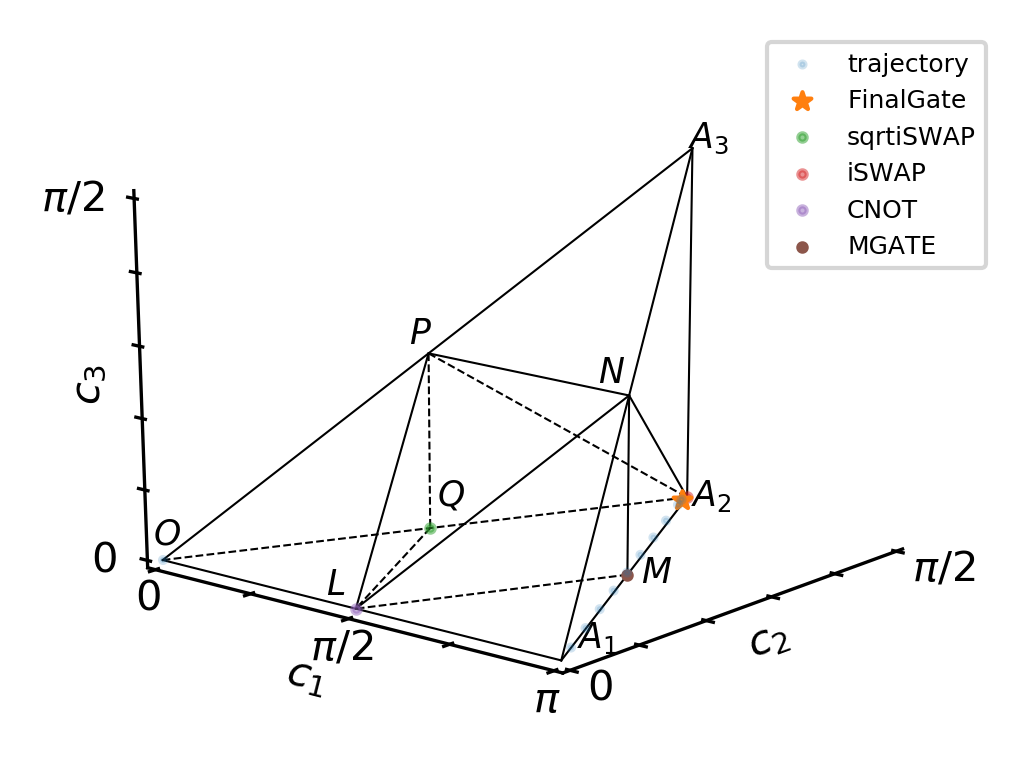

In [10]:
MGATE     = weylchamber.canonical_gate(3/4, 1/4, 0)
kwargs = {'marker':'o'}

w = WeylChamber()
w.fig_size=(3,3)
w.add_point(*zip(*iSWAP_weyl), scatter_index=0, alpha=0.2, s=2, label='trajectory')
w.add_point(*iSWAP_weyl[-1], scatter_index=1, alpha=1, marker='*', label='FinalGate')
w.add_point(*weylchamber.c1c2c3(sqrtiswap()), scatter_index=2, label='sqrtiSWAP', alpha=0.5, s=4)
w.add_point(*weylchamber.c1c2c3(iswap()), scatter_index=3, label='iSWAP', alpha=0.5, s=4)
w.add_point(*weylchamber.c1c2c3(cnot()), scatter_index=4, label='CNOT', alpha=0.5, s=4)
w.add_point(*weylchamber.c1c2c3(MGATE), scatter_index=5, label='MGATE', alpha=1, s=4)
w.plot()
plt.legend(fontsize=6)
plt.show()

# Set entangling pulse drive amplitude to a higher strength. Simulate nonstandard iSWAP-like entanglement

12.2%. Run time:   2.35s. Est. time left: 00:00:00:16
22.0%. Run time:   2.37s. Est. time left: 00:00:00:08
31.7%. Run time:   2.39s. Est. time left: 00:00:00:05
41.5%. Run time:   2.47s. Est. time left: 00:00:00:03
51.2%. Run time:   4.50s. Est. time left: 00:00:00:04
61.0%. Run time:   4.53s. Est. time left: 00:00:00:02
70.7%. Run time:   4.55s. Est. time left: 00:00:00:01
80.5%. Run time:   4.57s. Est. time left: 00:00:00:01
90.2%. Run time:   4.65s. Est. time left: 00:00:00:00
100.0%. Run time:   6.43s. Est. time left: 00:00:00:00
Total run time:   6.45s
Pop transfer:  0.9991360030172237


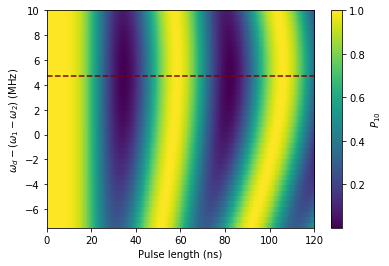

In [11]:
#################
#################
#################
### Important parameters to change

# delta is the entangling pulse drive strength. A nonstandard trajectory will result from strong drive effects/stark shifting
delta = 0.04 # delta <0.01 should give a standard trajectory. Above >0.01 trajectory should deviate more and more
max_tlist = 120e-9 # This number (in s) is the x axis limit of the below plot. It should be long enough to see an iSWAP.
# Once you know the iSWAP length, you can change the next cell max_tlist accordingly so your trajectory can reach iSWAP.

#################
#################
#################

# %%
# Find dressed frequencies and states
H = (Hs+omegaTB(params['Theta'], params)*nTB)
eigvals, eigvecs = H.eigenstates()
index = np.argmax(qt.expect(psiBare[0]*psiBare[0].dag(), eigvecs))
psiD10 = eigvecs[index]
omegaD10 = eigvals[index]
index = np.argmax(qt.expect(psiBare[1]*psiBare[1].dag(), eigvecs))
psiD01 = eigvecs[index]
omegaD01 = eigvals[index]
index = np.argmax(qt.expect(psiBare[2]*psiBare[2].dag(), eigvecs))
psiDTB = eigvecs[index]
omegaDTB = eigvals[index]
# %%

# Find dressed frequencies and states

U, s, V = np.linalg.svd(H.full())
permut_order = np.argmax(np.abs(V), axis=0)
undo_permut = np.arange(len(permut_order))
undo_permut[permut_order] = range(len(permut_order))
# s_ord = s[permut_order]
V_ord = V[permut_order, :]
U_ord = U[:, permut_order]
V_op = qt.Qobj(V_ord, dims = [[3,3,3], [3,3,3]])
U_op = qt.Qobj(U_ord, dims = [[3,3,3], [3,3,3]])
#
eops = [U_op*psiBare[0]*psiBare[0].dag()*U_op.dag(), U_op*psiBare[1]*psiBare[1].dag()*U_op.dag()]#
# eops = [psiD10*psiD10.dag(), psiD01*psiD01.dag()]
cops = []
# Include T1, T2 & temperature in simulation.
# This will take much more time and finer time steps. I haven't tried this yet.
#for ii in range(0, 2):
#    cops.append(np.sqrt(1/T1[ii])*a[ii])
#    cops.append(np.sqrt(1/T2[ii]-1/(2*T1[ii]))*(a[ii].dag()*a[ii]))
psi0 = psiD10
omegaPhi0 = omegaD10 - omegaD01
tlist = np.linspace(0, max_tlist, 501)
#tlist = np.linspace(0, 0.5e-6, 501)
omegaPhi = np.linspace(omegaPhi0-7.5e6*2*np.pi, omegaPhi0+10e6*2*np.pi, 41)
# omegaPhi = np.linspace(omegaPhi0, omegaPhi0+30e6*2*np.pi, 41)

args = {'delta'   : delta,
        'pulse_dur':max_tlist,
        'σ'       : 10e-9,
        'pulsed'  : True
             }
result = np.array(qt.parallel_map(fluxPump, omegaPhi,
                                  task_args=(psi0, tlist, args),
                                  progress_bar=True))
# %%
p10M = result[:, 0, :]
p01M = result[:, 1, :]
print('Pop transfer: ',np.max(p01M))
omegaPhi_iSWAP = omegaPhi[np.argmin(np.min(p10M,axis=1))] #figure out the drive freq

plt.close(2)
plt.figure(2)
# plt.plot(p10M[26])
# plt.show()
plt.imshow(p10M, origin='lower', aspect='auto',
           extent=[tlist[0]/1e-9, tlist[-1]/1e-9,
                   (omegaPhi[0]-omegaPhi0)/(2*np.pi)/1e6,
                   (omegaPhi[-1]-omegaPhi0)/(2*np.pi)/1e6])
plt.hlines(y=(omegaPhi_iSWAP-omegaPhi0)/(2*np.pi)/1e6, xmin=0, xmax = tlist[-1]/1e-9, linestyle='--', color='maroon')
plt.colorbar(label='$P_{10}$')
plt.xlabel('Pulse length (ns)')
plt.ylabel(r'$\omega_d - (\omega_1-\omega_2)$ (MHz)')
plt.show()

## Simulate the Cartan trajectory at this higher entangling pulse drive strength

In [12]:
#################
#################
#################
### Important parameters to change

t_f_max =40e-9 # This number (in s) is the max entangling pulse duration. It should be roughly the length of an iSWAP.

#################
#################
#################

num_pts = 11 # number of trajectory points to calculate
t_f_list = np.linspace(4e-9, t_f_max, num_pts)

args = {'omegaPhi': omegaPhi_iSWAP,
        'delta'   : delta,
        'pulse_dur':400e-9,
        'σ'       : 10e-9,
        'pulsed'  : True
             }
start = time.time()
iSWAP_weyl = []
iSWAP_leak = []
for t_f in t_f_list:
    #print(t_f)
    tlist = np.linspace(0, t_f, int(t_f/0.5e-9))
    args['pulse_dur'] = t_f #-0.04e-6 # 
    weyl, leak = fluxPump_weyl(tlist, args)
    #print("len of weyl array",len(weyl)) it is 1
    iSWAP_weyl.append(weyl[0])
    #print(weyl[0])
    iSWAP_leak.append(leak[0])
    #print(leak[0])
    print("Time elapsed: ", time.time()-start)
print("Finished.")

Time elapsed:  0.5137691497802734
Time elapsed:  1.252413272857666
Time elapsed:  2.358293294906616
Time elapsed:  3.9214282035827637
Time elapsed:  5.6757049560546875
Time elapsed:  7.600231885910034
Time elapsed:  9.974921941757202
Time elapsed:  12.531251907348633
Time elapsed:  15.416512966156006
Time elapsed:  18.516797304153442
Time elapsed:  21.864817142486572
Finished.


## Plot the simulated Cartan trajectory in the Weyl chamber

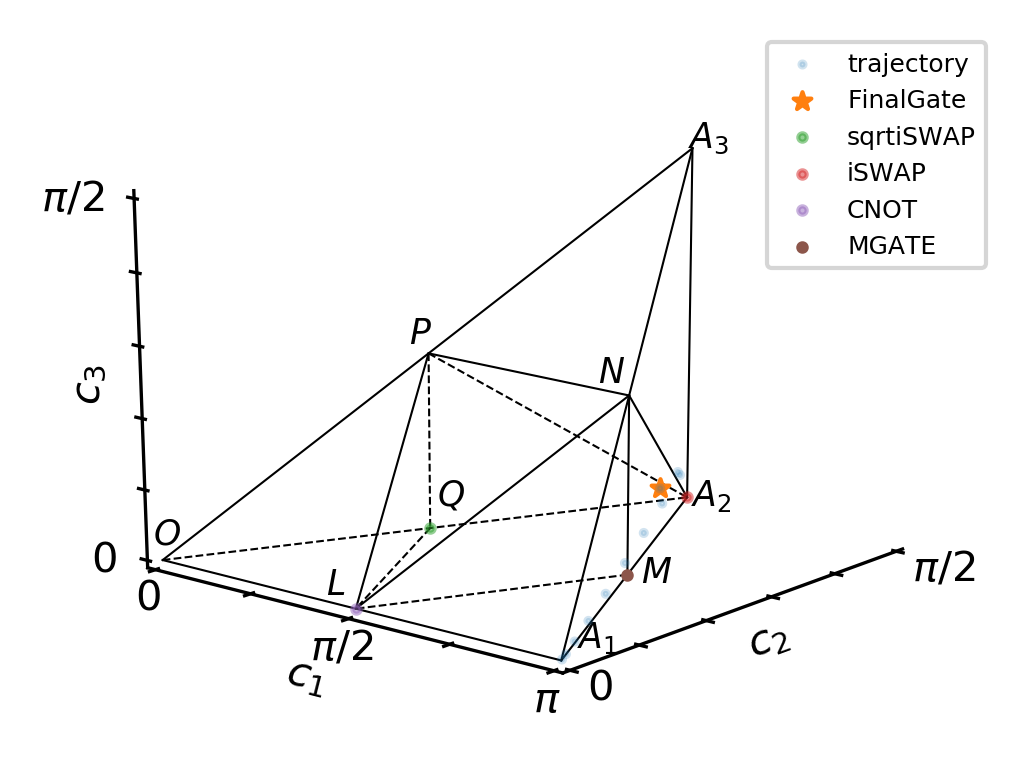

In [13]:
MGATE     = weylchamber.canonical_gate(3/4, 1/4, 0)
kwargs = {'marker':'o'}

w = WeylChamber()
w.fig_size=(3,3)
w.add_point(*zip(*iSWAP_weyl), scatter_index=0, alpha=0.2, s=2, label='trajectory')
w.add_point(*iSWAP_weyl[-1], scatter_index=1, alpha=1, marker='*', label='FinalGate')
w.add_point(*weylchamber.c1c2c3(sqrtiswap()), scatter_index=2, label='sqrtiSWAP', alpha=0.5, s=4)
w.add_point(*weylchamber.c1c2c3(iswap()), scatter_index=3, label='iSWAP', alpha=0.5, s=4)
w.add_point(*weylchamber.c1c2c3(cnot()), scatter_index=4, label='CNOT', alpha=0.5, s=4)
w.add_point(*weylchamber.c1c2c3(MGATE), scatter_index=5, label='MGATE', alpha=1, s=4)
w.plot()
plt.legend(fontsize=6)
plt.show()